## МЕТОД ГЛАВНЫХ КОМПОНЕНТ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
train, validation, test = load_mnist()
X_train, y_train = train
X_test, y_test = test

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [3]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(55000, 28, 28, 1) (55000,)
(10000, 28, 28, 1) (10000,)


# I. Визуализация датасета

Нарисуем несколько примеров картинок из X_train

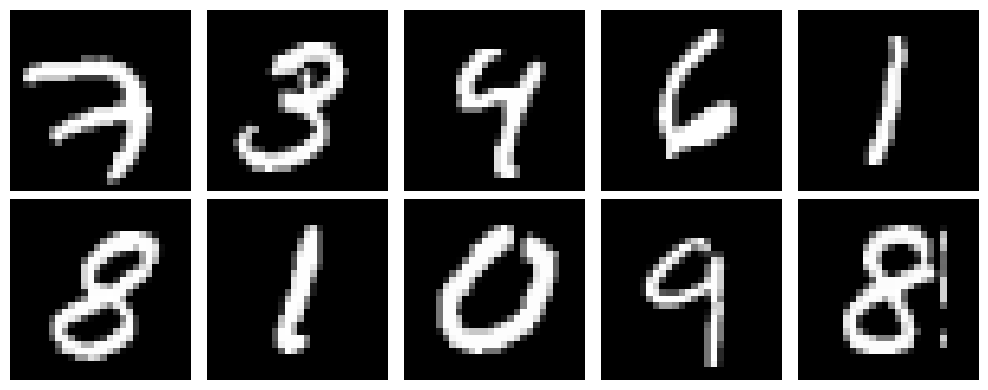

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# II. Алгоритм PCA

Реализация алгоритма PCA 

In [5]:
class my_PCA():
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.eigenvalues = None

    def fit(self, X):
        mean = np.mean(X, axis=0)
        X_centered = X - mean
        
        cov_matrix = np.cov(X_centered.T)
        
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        
        self.components = sorted_eigenvectors[:, :self.n_components]
        self.eigenvalues = sorted_eigenvalues[:self.n_components]

    def transform(self, X):
        X_transformed = np.dot(X, self.components)
        return X_transformed

Преобразуем данные в одномерные векторы и применяем к ним РСА

In [6]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

pca = my_PCA(n_components = 64)
pca.fit(X_train)

Строим график собственных значений и график кумулятивной суммы собственных значений. Выводим изображение точек датасета в первых двух координатах главных компонент

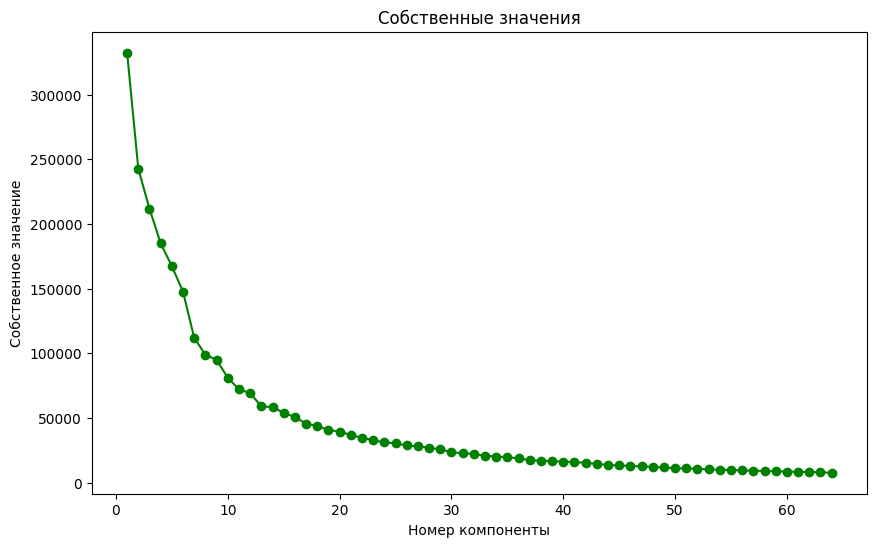

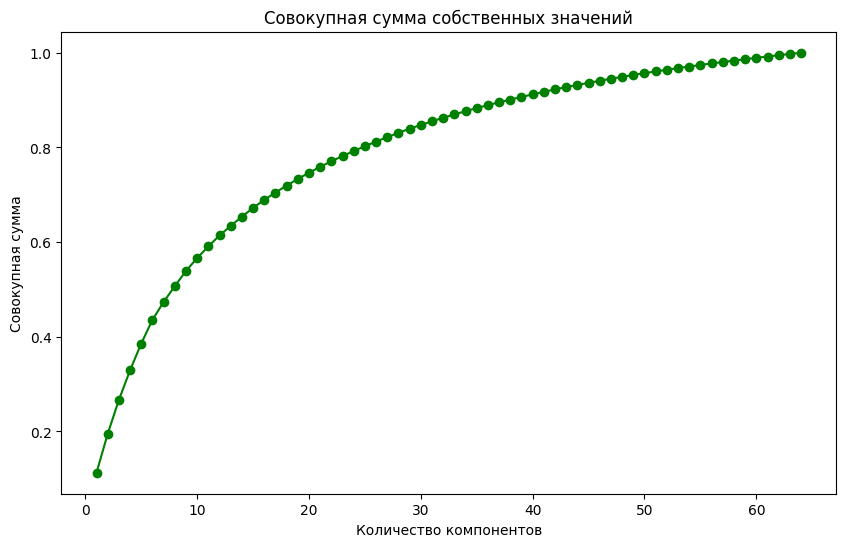

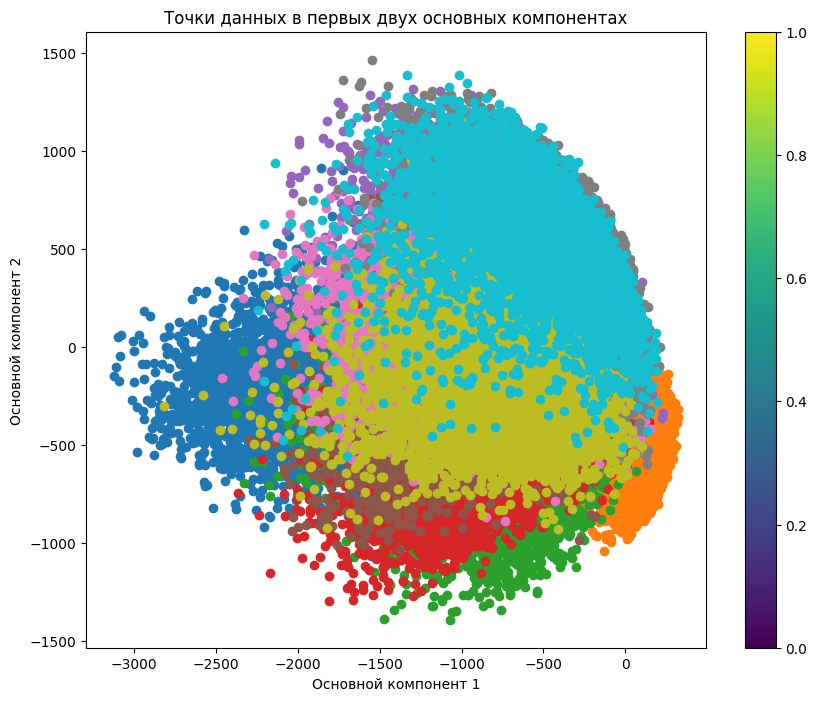

In [7]:
plt.figure(figsize = (10, 6))
plt.plot(np.arange(1, pca.n_components + 1), pca.eigenvalues, marker = 'o', linestyle = '-', color = 'g')
plt.xlabel('Номер компоненты')
plt.ylabel('Собственное значение')
plt.title('Собственные значения')
plt.show()

cumulative_sum = np.cumsum(pca.eigenvalues) / np.sum(pca.eigenvalues)
plt.figure(figsize = (10, 6))
plt.plot(np.arange(1, pca.n_components + 1), cumulative_sum, marker = 'o', linestyle = '-', color = 'g')
plt.xlabel('Количество компонентов')
plt.ylabel('Совокупная сумма')
plt.title('Совокупная сумма собственных значений')
plt.show()

X_transformed = pca.transform(X_train)
plt.figure(figsize=(10, 8))
for label in np.unique(y_train):
    plt.scatter(X_transformed[y_train == label, 0], X_transformed[y_train == label, 1], label=str(label))
plt.xlabel('Основной компонент 1')
plt.ylabel('Основной компонент 2')
plt.title('Точки данных в первых двух основных компонентах')
plt.colorbar()
plt.show()

# III. Алгоритм kNN

Реализация алгоритма kNN

In [8]:
class my_kNN():
    def __init__(self, n_neighbors = 5):
        self.n_neighbors = n_neighbors
        self.model = None

    def fit(self, X, y):
        self.model = KNeighborsClassifier(n_neighbors = self.n_neighbors)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy

Разбиваем данные на обучающую и тестовую выборку

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(49500, 784) (49500,)
(5500, 784) (5500,)


Создаем и обучаем классификатор kNN. Предсказываем на тестовой выборке и оцениваем точность алгоритма kNN

In [15]:
pca = my_PCA(n_components = 1)
pca.fit(X_train)

knn = my_kNN(n_neighbors = 1)
knn.fit(X_train, y_train)

accuracy = knn.evaluate(X_test, y_test) * 100
print("Точность: {:.2f}%".format(accuracy))

Точность: 97.13%


In [12]:
pca = my_PCA(n_components = 20)
pca.fit(X_train)

knn = my_kNN(n_neighbors = 5)
knn.fit(X_train, y_train)

accuracy = knn.evaluate(X_test, y_test) * 100
print("Точность: {:.2f}%".format(accuracy))

Точность: 97.00%


In [13]:
best_accuracy = 0
best_params = {}

components_step = 4
neighbors_step = 3

n_components_range = range(components_step, 65, components_step)
n_neighbors_range = range(neighbors_step, 31, neighbors_step)

accuracy_matrix = np.zeros((len(n_components_range), len(n_neighbors_range)))

for n_components in range(components_step, 65, components_step):
    for n_neighbors in range(neighbors_step, 31, neighbors_step):
        pca = my_PCA(n_components = n_components)
        pca.fit(X_train)

        knn = my_kNN(n_neighbors = n_neighbors)
        knn.fit(X_train, y_train)

        accuracy = knn.evaluate(X_test, y_test) * 100
        accuracy_matrix[(int)(n_components/components_step-1), (int)(n_neighbors/neighbors_step-1)] = accuracy
        print("Количество компонент: {}, Количество соседей: {}, Точность: {:.2f}%".format(n_components, n_neighbors, accuracy))

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['Количество компонент'] = n_components
            best_params['Количество соседей'] = n_neighbors

print()
print("Наилучшая точность: {:.2f}%".format(best_accuracy))
print("Наилучшие параметры:", best_params)

Количество компонент: 4, Количество соседей: 3, Точность: 96.96%
Количество компонент: 4, Количество соседей: 6, Точность: 96.56%
Количество компонент: 4, Количество соседей: 9, Точность: 96.58%
Количество компонент: 4, Количество соседей: 12, Точность: 96.38%
Количество компонент: 4, Количество соседей: 15, Точность: 96.16%
Количество компонент: 4, Количество соседей: 18, Точность: 95.96%
Количество компонент: 4, Количество соседей: 21, Точность: 95.82%
Количество компонент: 4, Количество соседей: 24, Точность: 95.80%
Количество компонент: 4, Количество соседей: 27, Точность: 95.58%
Количество компонент: 4, Количество соседей: 30, Точность: 95.38%
Количество компонент: 8, Количество соседей: 3, Точность: 96.96%
Количество компонент: 8, Количество соседей: 6, Точность: 96.56%
Количество компонент: 8, Количество соседей: 9, Точность: 96.58%
Количество компонент: 8, Количество соседей: 12, Точность: 96.38%
Количество компонент: 8, Количество соседей: 15, Точность: 96.16%
Количество компо

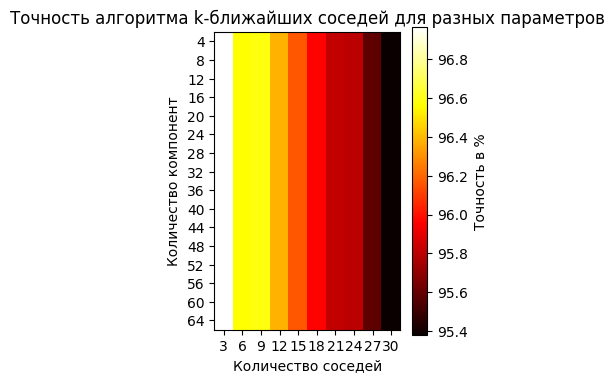

In [14]:
plt.figure(figsize = (neighbors_step, components_step))
plt.imshow(accuracy_matrix, cmap = 'hot', interpolation = 'nearest')
plt.colorbar(label = 'Точность в %')
plt.xticks(np.arange(len(n_neighbors_range)), n_neighbors_range)
plt.xlabel('Количество соседей')
plt.yticks(np.arange(len(n_components_range)), n_components_range)
plt.ylabel('Количество компонент')
plt.title('Точность алгоритма k-ближайших соседей для разных параметров')
plt.show()

# Вывод

При применении алгоритма k-ближайших соседей (kNN) на данных, преобразованных с использованием PCA, была достигнута точность 97.13% с наилучшими параметрами: 1 компонент и 1 сосед. 

PCA позволяет снизить размерность данных, сохраняя при этом наиболее важные характеристики. Это может быть полезно для улучшения эффективности алгоритмов машинного обучения и сокращения времени обучения. Комбинация PCA и kNN представляет собой мощный инструмент для классификации данных. Она позволяет учесть влияние наиболее информативных компонент и учитывать близость к соседним объектам при принятии решений. Однако стоит отметить, что выбор оптимальных параметров для PCA (количество компонент) и kNN (количество соседей) может потребовать некоторого исследования и настройки. В данном случае была использована реализация PCA и kNN, созданная самостоятельно. Однако существуют и другие библиотечные реализации этих алгоритмов, которые могут быть удобными и эффективными в реальных задачах. 

В целом, применение PCA и kNN вместе может быть полезным инструментом для анализа и классификации данных, и эти методы могут быть применены в различных областях, включая компьютерное зрение, распознавание образов, биометрию и другие.